In [8]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [9]:
raw_data = pd.read_csv('data/clean_data.csv')

In [10]:
raw_data.head()

,Yr,Reporting_Entity_RIC_Name,Partner_Entity_RIC_Name,Flow,Reporting_Entity_Continent,Reporting_Entity_Type,Partner_Entity_Continent,Partner_Entity_Type
0,1792,France,Austria,13541271.0,Europe,Country,Europe,Country
1,1792,France,Germany,12300406.0,Europe,Country,Europe,Country
2,1792,France,Netherlands,21864951.0,Europe,Country,Europe,Country
3,1792,France,Portugal,1334107.0,Europe,Country,Europe,Country
4,1792,France,Prussia,2294328.0,Europe,Country,Europe,Country


### GTC_Functions

In [11]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# data importing
raw_data = pd.read_csv('data/clean_data.csv')

class Graph_GT:
    def __init__(self, year, raw_data = raw_data):
        """
        Initialization
        self.df is a pd.dataframe for the given year
        """

        self.year = year
        self.df = raw_data.loc[raw_data['Yr']==year]
 

    def country_list(self):
        """
        raw_date should be a pd.dataframe
        
        """
        country_list = set(list(self.df.Reporting_Entity_RIC_Name)\
                           +list(self.df.Partner_Entity_RIC_Name))
        country_list = sorted(list(country_list))
        return country_list
    
    
    def graph(self):
        """
        creat a nx.graph object(weighted & directed)
        of the trading data for the given year
        """
        
        list_trade = self.df.iloc[:,[1,2,3]].values
#         list_trade_nanremoved = []
#         for row in list_trade:
#             if np.isnan(row[2]) == False:
#                 list_trade_nanremoved +=  [row]
        list_trade = np.array(list_trade)

        #min_max_scaler = preprocessing.MinMaxScaler()
        #
        #list_trade[:,2] = min_max_scaler.fit_transform(list_trade[:,2])       
        #list_trade[:,2] = preprocessing.scale(list_trade[:,2])

        G = nx.Graph()
        nodes = []
        for row in list_trade:

            G.add_edge(row[0],row[1])
            nodes.append(row[0])
            nodes.append(row[1])
        nodes = set(nodes)
        G.add_nodes_from(nodes)
        return G
    


In [90]:
G = Graph_GT(year = 1880).graph()
k_community=6

## Louvain Methode

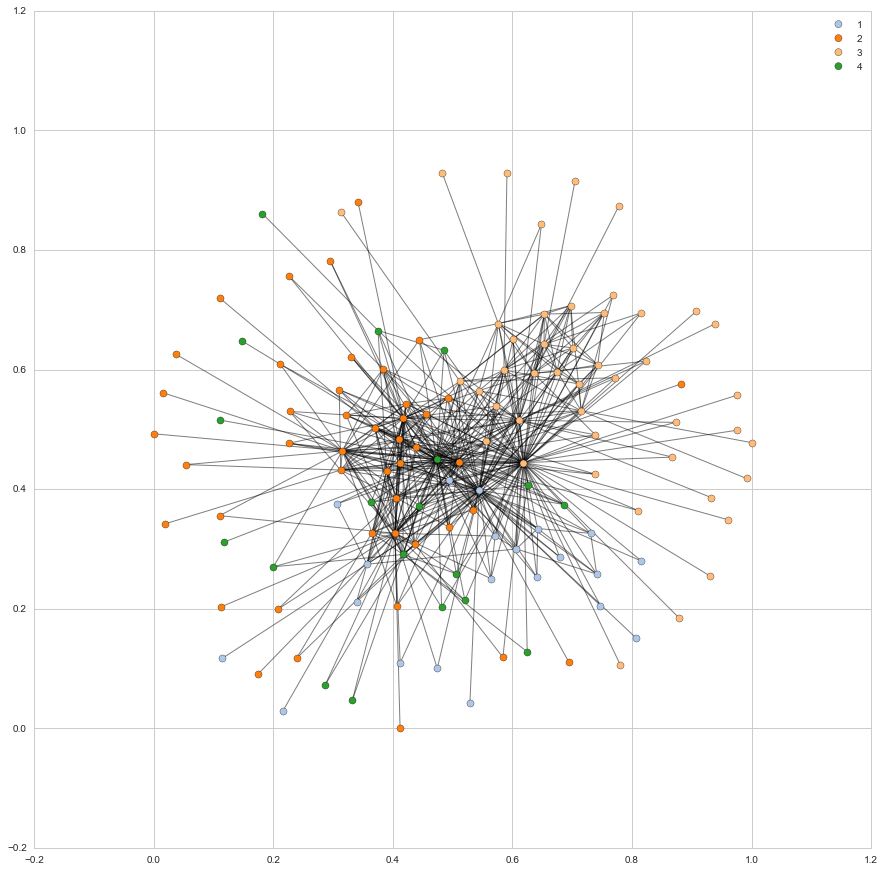

In [91]:
import community_louvain

plt.figure(figsize = [15,15])
#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure

#first compute the best partition
dict_predict_louvain = community_louvain.best_partition(G)

#drawing
size = float(len(set(dict_predict_louvain.values())))
pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
          ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
          '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']

for com in set(dict_predict_louvain.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict_louvain.keys()
                                if dict_predict_louvain[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()

## Spectral Clustering

In [92]:
Lap_nom = nx.normalized_laplacian_matrix(G).todense()

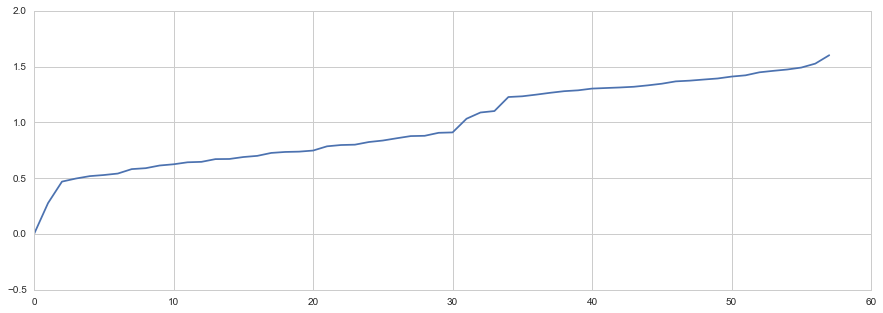

In [93]:
plt.figure(figsize = [15,5])
eig_val, eig_vec = np.linalg.eig(Lap_nom)
plt.plot(sorted(np.linalg.eig(Lap_nom)[0][0:58]))

In [94]:
k = 10
selected_vec = np.zeros([len(eig_val),k])
thr = sorted(eig_val)[k-1]
eig_val, eig_vec = np.linalg.eig(Lap_nom)
ind = 0
for i in range(len(eig_val)):
    if eig_val[i]<=thr:
        selected_vec[:,ind] = np.array(eig_vec)[:,i]
        ind += 1
        

In [95]:
X = selected_vec

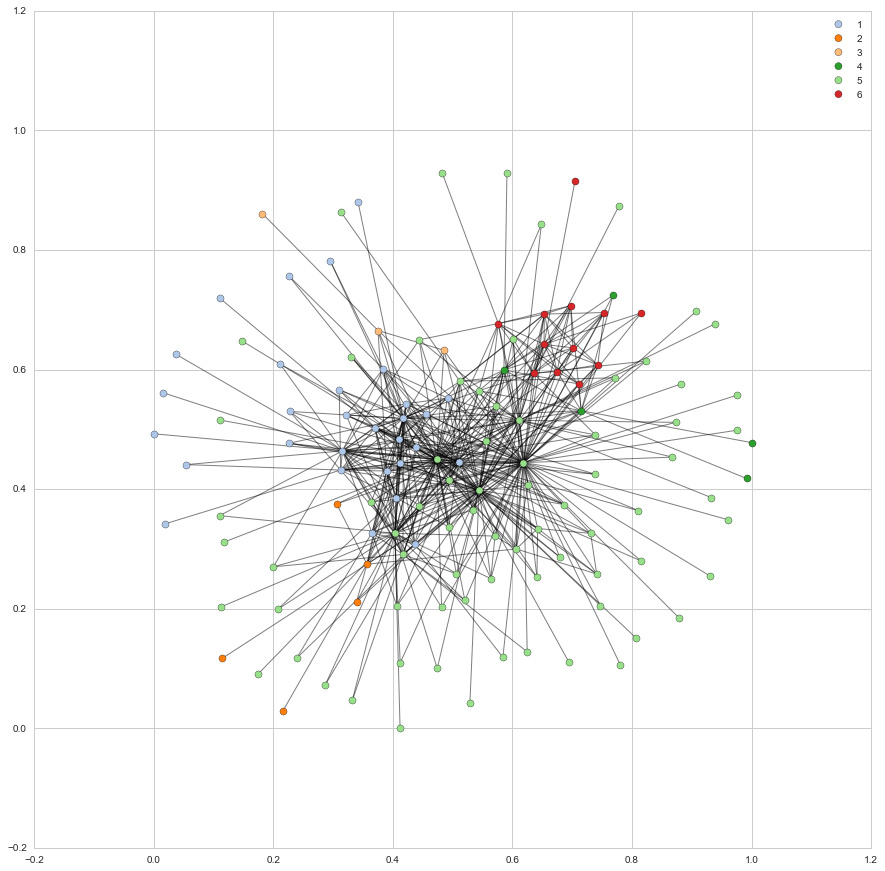

In [96]:
cluster_km = KMeans(n_clusters = k_community,max_iter = 10000,tol = 0.00000001)
features_spectre = X
cluster_km.fit(features_spectre)
pred = cluster_km.predict(X)

dict_predict_spec = {}
for i in range(len(G.nodes())):
    dict_predict_spec.update(
    {
            G.nodes()[i] : int(pred[i])
        })

plt.figure(figsize = [15,15])
count = 0
for com in set(dict_predict_spec.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict_spec.keys()
                                if dict_predict_spec[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()


## Girvan-Newman Clustering

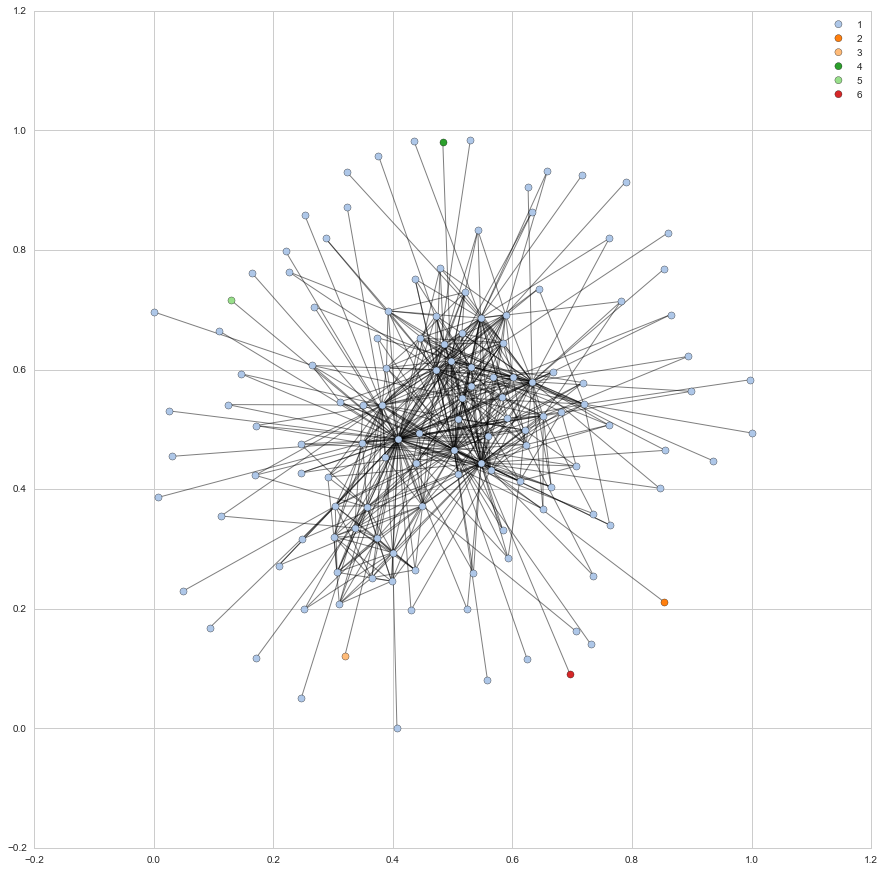

In [97]:
import centrality
import itertools

comp = centrality.girvan_newman(G)

limited = itertools.takewhile(lambda c: len(c) <= k_community, comp)
ls=[]
depth=0
dict_predict_newman = {}
for communities in limited:
#     ls += [list(sorted(c) for c in communities)]
#     print(list(sorted(c) for c in communities))
    depth+=1
    if depth==k_community-1:
        for i in range(len(communities)):
            for d in communities[i]:
                dict_predict_newman.update({
                        d:i
                    })
                
community_louvain.modularity(dict_predict_newman,G)

plt.figure(figsize = [15,15])
count = 0
pos = nx.fruchterman_reingold_layout(G)
colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
          ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
          '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']

for com in set(dict_predict_newman.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict_newman.keys()
                                if dict_predict_newman[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()

## Calculation of Modulartiy

In [98]:
modu_1880 = [community_louvain.modularity(dict_predict_louvain, G),\
                   community_louvain.modularity(dict_predict_spec, G),\
                   community_louvain.modularity(dict_predict_newman, G)]

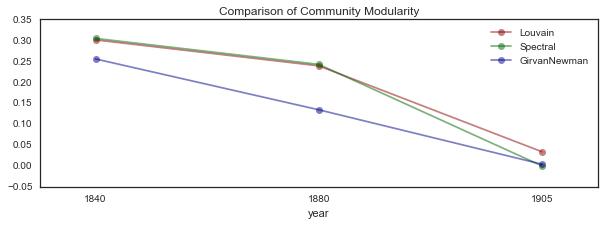

In [123]:
plt.figure(figsize = [10,3])
list_year = [1840,1880,1905]
sns.set_style("white")

plt.plot(range(3),modu_1840, color = 'darkred',label = "Louvain",marker = 'o',alpha=0.5)
plt.plot(range(3),modu_1880, color = 'darkgreen',label = "Spectral",marker = 'o',alpha=0.5)
plt.plot(range(3),modu_1905, color = 'darkblue',label = "GirvanNewman",marker = 'o',alpha=0.5)
plt.xticks(range(3),list_year)

plot_margin = 0.25

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 ,y1))
plt.xlabel("year")
plt.title("Comparison of Community Modularity")
plt.legend()

## Calculation of Conductance 

In [124]:
from __future__ import division

from itertools import chain

import networkx as nx

__all__ = ['boundary_expansion', 'conductance', 'cut_size', 'edge_expansion',
           'mixing_expansion', 'node_expansion', 'normalized_cut_size',
           'volume']

def cut_size(G, S, T=None, weight=None):
    """Returns the size of the cut between two sets of nodes.

    A *cut* is a partition of the nodes of a graph into two sets. The
    *cut size* is the sum of the weights of the edges "between" the two
    sets of nodes.

    Parameters
    ----------
    G : NetworkX graph

    S : sequence
        A sequence of nodes in `G`.

    T : sequence
        A sequence of nodes in `G`. If not specified, this is taken to
        be the set complement of `S`.

    weight : object
        Edge attribute key to use as weight. If not specified, edges
        have weight one.

    Returns
    -------
    number
        Total weight of all edges from nodes in set `S` to nodes in
        set `T` (and, in the case of directed graphs, all edges from
        nodes in `T` to nodes in `S`).

    Examples
    --------
    In the graph with two cliques joined by a single edges, the natural
    bipartition of the graph into two blocks, one for each clique,
    yields a cut of weight one::

        >>> G = nx.barbell_graph(3, 0)
        >>> S = {0, 1, 2}
        >>> T = {3, 4, 5}
        >>> nx.cut_size(G, S, T)
        1

    Each parallel edge in a multigraph is counted when determining the
    cut size::

        >>> G = nx.MultiGraph(['ab', 'ab'])
        >>> S = {'a'}
        >>> T = {'b'}
        >>> nx.cut_size(G, S, T)
        2

    Notes
    -----
    In a multigraph, the cut size is the total weight of edges including
    multiplicity.

    """
    edges = nx.edge_boundary(G, S, T)
    if G.is_directed():
        edges = chain(edges, nx.edge_boundary(G, T, S))
    return sum(1 for u, v in edges)




def volume(G, S):
    """Returns the volume of a set of nodes.

    """
    degree = G.degree
    #return sum(d for v, d in degree(S))
    return len(S)





def conductance(G, S, T=None, weight=None):
    """Returns the conductance of two sets of nodes.

    The *conductance* is the quotient of the cut size and the smaller of
    the volumes of the two sets. [1]

    Parameters
    ----------
    G : NetworkX graph

    S : sequence
        A sequence of nodes in `G`.

    T : sequence
        A sequence of nodes in `G`.

    weight : object
        Edge attribute key to use as weight. If not specified, edges
        have weight one.

    Returns
    -------
    number
        The conductance between the two sets `S` and `T`.

    See also
    --------
    cut_size
    edge_expansion
    normalized_cut_size
    volume

    References
    ----------
    .. [1] David Gleich.
           *Hierarchical Directed Spectral Graph Partitioning*.
           <https://www.cs.purdue.edu/homes/dgleich/publications/Gleich%202005%20-%20hierarchical%20directed%20spectral.pdf>

    """
    if T is None:
        T = set(G) - set(S)
    num_cut_edges = cut_size(G, S, T)
    volume_S = volume(G, S)
    volume_T = volume(G, T)
    return num_cut_edges / min(volume_S, volume_T)


In [125]:
def get_cluster_nodes_from_dict(cluster_index,dict_predict):
    """
    return the nodes of a certain cluster
    """
    return {k:v for (k,v) in dict_predict.items() if v==cluster_index}.keys()

In [126]:
def conductance_by_index(index_1, index_2,dict_predict = dict_predict_louvain, G = G):
    return conductance(G,get_cluster_nodes_from_dict(index_1,dict_predict),get_cluster_nodes_from_dict(index_2,dict_predict))

In [127]:
def normalized_conductance(dict_predict,G=G):
    """
    Calculate nomarlized conductance:
    total conductance/number of couples
    """
    list_index = list(set(dict_predict.values()))
    conductance_tol = 0
    
    for i in list_index:
        for j in list_index:
            if i != j:
                conductance_tol += conductance_by_index(i,j,dict_predict,G)
    return conductance_tol/float(len(list_index)*(len(list_index)-1))/2.

In [128]:
cond_1880 = [normalized_conductance(dict_predict_louvain),normalized_conductance(dict_predict_spec),\
 normalized_conductance(dict_predict_newman)]


In [129]:
plt.figure(figsize = [10,3])
list_year = [1840,1880,1905]
plt.plot(range(3),cond_1840, color = 'darkred',label = "Louvain",marker = 'o',alpha=0.5)
plt.plot(range(3),cond_1880, color = 'darkgreen',label = "Spectral",marker = 'o',alpha=0.5)
plt.plot(range(3),cond_1905, color = 'darkblue',label = "GirvanNewman",marker = 'o',alpha=0.5)
plt.xticks(range(3),list_year)

plot_margin = 0.25

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 ,y1))
plt.xlabel("year")
plt.title("Comparison of Community Conductance")plt.legend()

SyntaxError: invalid syntax (<ipython-input-129-7ca6449cdd86>, line 15)

## Community Quality

In [130]:
import community_quality
import minors

In [131]:
def partition(dict_predict):
    n_cluster = len(set(dict_predict.values()))
    partition = [[] for i in range(n_cluster)]
    for i in range(n_cluster):
        for d in dict_predict:
            if(dict_predict[d])==i:
                partition[i].append(d)
    partition=[set(ls) for ls in partition]
    return partition

In [132]:
# partition=partition(dict_predict_louvain)

In [133]:
# coverage=community_quality.coverage(G,partition(dict_predict_louvain))
# coverage
cov_1880=[community_quality.coverage(G,partition(dict_predict_louvain)),\
               community_quality.coverage(G,partition(dict_predict_spec)),\
               community_quality.coverage(G,partition(dict_predict_newman))]

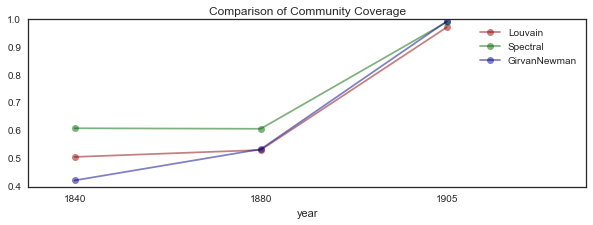

In [139]:
plt.figure(figsize = [10,3])
list_year = [1840,1880,1905]
plt.plot(range(3),cov_1840, color = 'darkred',label = "Louvain",marker = 'o',alpha=0.5)
plt.plot(range(3),cov_1880, color = 'darkgreen',label = "Spectral",marker = 'o',alpha=0.5)
plt.plot(range(3),cov_1905, color = 'darkblue',label = "GirvanNewman",marker = 'o',alpha=0.5)
plt.xticks(range(3),list_year)

plot_margin = 0.25

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + 3*plot_margin,
          y0 ,y1))
plt.xlabel("year")
plt.title("Comparison of Community Coverage")
plt.legend()

In [135]:
# intra=community_quality.intra_community_edges(G,partition)
# print intra

# inter=community_quality.inter_community_edges(G,partition)
# print inter

In [136]:
# is_partition=community_quality.is_partition(G,partition)
# is_partition
perf_1880=[community_quality.performance(G,partition(dict_predict_louvain)),\
               community_quality.performance(G,partition(dict_predict_spec)),\
               community_quality.performance(G,partition(dict_predict_newman))]

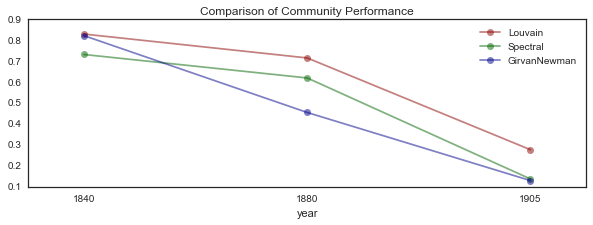

In [137]:
plt.figure(figsize = [10,3])
list_year = [1840,1880,1905]
plt.plot(range(3),perf_1840, color = 'darkred',label = "Louvain",marker = 'o',alpha=0.5)
plt.plot(range(3),perf_1880, color = 'darkgreen',label = "Spectral",marker = 'o',alpha=0.5)
plt.plot(range(3),perf_1905, color = 'darkblue',label = "GirvanNewman",marker = 'o',alpha=0.5)
plt.xticks(range(3),list_year)

plot_margin = 0.25

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 ,y1))
plt.xlabel("year")
plt.title("Comparison of Community Performance")
plt.legend()

## Overlapping clustering

In [ ]:
from collections import defaultdict
import networkx as nx

__all__ = ['k_clique_communities']


def k_clique_communities(G, k, cliques=None):
    """Find k-clique communities in graph using the percolation method.

    A k-clique community is the union of all cliques of size k that
    can be reached through adjacent (sharing k-1 nodes) k-cliques.

    Parameters
    ----------
    G : NetworkX graph

    k : int
       Size of smallest clique

    cliques: list or generator       
       Precomputed cliques (use networkx.find_cliques(G))

    Returns
    -------
    Yields sets of nodes, one for each k-clique community.

    Examples
    --------
    >>> G = nx.complete_graph(5)
    >>> K5 = nx.convert_node_labels_to_integers(G,first_label=2)
    >>> G.add_edges_from(K5.edges())
    >>> c = list(nx.k_clique_communities(G, 4))
    >>> list(c[0])
    [0, 1, 2, 3, 4, 5, 6]
    >>> list(nx.k_clique_communities(G, 6))
    []

    References
    ----------
    .. [1] Gergely Palla, Imre Derényi, Illés Farkas1, and Tamás Vicsek,
       Uncovering the overlapping community structure of complex networks 
       in nature and society Nature 435, 814-818, 2005,
       doi:10.1038/nature03607
    """
    if k < 2:
        raise nx.NetworkXError("k=%d, k must be greater than 1."%k)
    if cliques is None:
        cliques = nx.find_cliques(G)
    cliques = [frozenset(c) for c in cliques if len(c) >= k]

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    for clique in cliques:
        for adj_clique in _get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def _get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

k_clique_coef = 6


overlap_list = []

for i in range(len(list(nx.k_clique_communities(G,k_clique_coef)))):
    
    overlap_list += [list(list(nx.k_clique_communities(G,k_clique_coef))[i])]

pred = []
for j in range(len(list(nx.k_clique_communities(G,k_clique_coef)))):
    for i in range(len(G.nodes())):
    
        if G.nodes()[i] in overlap_list[j]:
            pred += [j+1]
        else:
            pred +=[0]
    

dict_predict = {}
for i in range(len(G.nodes())):
    dict_predict.update(
    { G.nodes()[i] : int(pred[i])
        })

plt.figure(figsize = [15,15])

pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


# colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
#           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
#           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
colors = ['lightgrey', '#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
           ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
           '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']
for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count-1],label = count-1)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.2)
plt.title('overlapping detection k = '+ str(k_clique_coef))
plt.show()

dict_predict

## Global Stats

In [140]:
#connectivity
connectivity=nx.average_node_connectivity(G)
print connectivity

##cluster_coefficient
average_clustering=nx.average_clustering(G)
print average_clustering

0.5364058589581481

## Local stats

In [138]:
connectivity_pairs=nx.all_pairs_node_connectivity(G)
connectivity_pairs

{'Aden': {'Algeria': 2,
  'Argentina': 2,
  'Ascension I.': 1,
  'Australia': 2,
  'Austria': 2,
  'Austria-Hungary': 2,
  'Azores (Western Isles)': 2,
  'Baden': 1,
  'Barbados': 2,
  'Belgium': 2,
  'Belize (British Honduras)': 2,
  'Bermuda': 1,
  'Bolivia': 2,
  'Brazil': 2,
  'Bremen': 2,
  'British Virgin Is.': 2,
  'Buenos Aires': 1,
  'Bulgaria': 2,
  'Canada': 2,
  'Canary Is.': 1,
  'Cape Colony': 2,
  'Ceuta': 1,
  'Chile': 2,
  "China (People's Republic of China)": 2,
  'Colombia (Gran Colombia)': 2,
  'Costa Rica': 2,
  'Cuba': 2,
  'Curacao': 1,
  'Denmark': 2,
  'Dominican Republic (Santo Domingo)': 2,
  'Ecuador': 2,
  'Egypt/United Arab Republic': 2,
  'El Salvador': 2,
  'Falkland Is.': 2,
  'Fernando Po (Bioko)': 1,
  'Fiji': 2,
  'Finland': 2,
  'France': 2,
  'French Guyana': 2,
  'French India': 2,
  'French Indochina': 1,
  'Germany': 2,
  'Germany (Zollverein)': 1,
  'Ghana (Gold Coast)': 2,
  'Gibraltar': 2,
  'Greece': 2,
  'Guadeloupe': 1,
  'Guatemala': 2,
 

In [ ]:
rank=nx.pagerank(G)
sorted(rank.items(), key=lambda x:x[1],reverse=True)

In [ ]:
#centrality
centr=nx.closeness_centrality(G)
sorted(centr.items(), key=lambda x:x[1],reverse=True)

In [ ]:
btw=nx.betweenness_centrality(G)
sorted(btw.items(), key=lambda x:x[1],reverse=True)

In [ ]:
degree=nx.degree_centrality(G)
sorted(degree.items(), key=lambda x:x[1],reverse=True)